<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-07-07 07:47:52--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-07-07 07:47:52 (254 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn matplotlib -y

Solving environment: done

# All requested packages already installed.



In [8]:
!pip install matplotlib==3.1.3

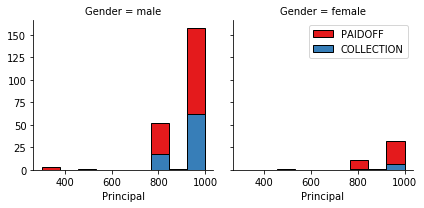

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

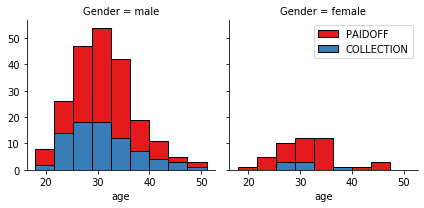

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


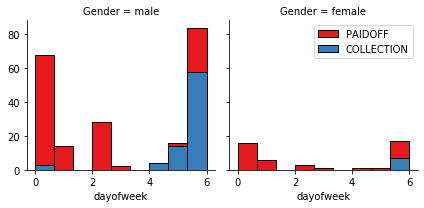

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## Metrics for evaluating performance
from sklearn.metrics import jaccard_score, f1_score, log_loss, classification_report, confusion_matrix
from sklearn import metrics

from collections import defaultdict

import itertools
import sklearn.preprocessing as preprocessing

### Split Data into Training and Testing Set

In [22]:
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=4)
print("Train X Shape: ",train_x.shape)
print("Train Y Shape: ",train_y.shape)
print("Test X Shape: ",test_x.shape)
print("Test Y Shape: ",test_y.shape)

Train X Shape:  (276, 8)
Train Y Shape:  (276,)
Test X Shape:  (70, 8)
Test Y Shape:  (70,)


**Method for quickly encoding the target values into numerical binary values**

In [23]:
def encode_loan_status(y):
    ycopy  = y.copy()
    ycopy[ycopy == 'COLLECTION'] = 0
    ycopy[ycopy == 'PAIDOFF']    = 1
    ycopy = ycopy.astype('int64')
    return ycopy

Test the range of **K's** from `1 - 10`

In [24]:
maxK = 10

# Arrays for storing the means and variance of K evaluations accordingly
mean_acc = np.zeros((maxK))
std_acc = np.zeros((maxK))

for i in range(1,maxK+1):
    knn = KNeighborsClassifier(n_neighbors=i).fit(train_x,train_y)
    yhat= knn.predict(test_x)
    mean_acc[i-1] = metrics.accuracy_score(test_y, yhat)
    std_acc[i-1]  =np.std(yhat==test_y)/np.sqrt(yhat.shape[0])

max_accuracy = mean_acc.max()
max_k        = mean_acc.argmax() + 1



def perform_KNN_evaluation(kstart,kend,X,Y,test_size=0.3,random_state=1):
    output_map = defaultdict(lambda : [])
    for i in range(kstart,kend+1,2):
        train_X, test_X, train_Y, test_Y = train_test_split(X,y,test_size=test_size,random_state=random_state)
        knn = KNeighborsClassifier(n_neighbors=i).fit(train_X,train_Y)
        yhat= knn.predict(test_X)
        yhat_prob = knn.predict_proba(test_X)
        
        yhat_encode   = encode_loan_status(yhat)
        test_Y_encode = encode_loan_status(test_Y)

        j_score       = jaccard_score(test_Y_encode,yhat_encode)
        f1            = f1_score(test_Y_encode,yhat_encode)
        metrics_score = metrics.accuracy_score(test_Y_encode,yhat_encode)
        logLoss       = log_loss(test_Y_encode,yhat_prob)
        
        output_map['k'].append(i)
        output_map['jaccard score'].append(j_score)
        output_map['f1 score'].append(f1)
        output_map['log loss'].append(logLoss)
        output_map['metrics'].append(metrics_score)
    df = pd.DataFrame(data = output_map)
    return df
print(mean_acc)

[0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286 0.67142857]


### Plot the Accuracy for Different Values of K ( from k=1 to k =10)

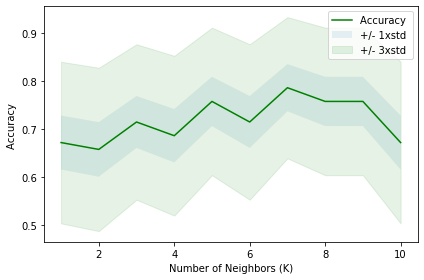

The optimal k is 7 with an accuracy of 0.785714


In [25]:
plt.plot(range(1,maxK+1),mean_acc,'g')
plt.fill_between(range(1,maxK+1),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,maxK+1),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print("The optimal k is %d with an accuracy of %f" % (max_k,max_accuracy))

### Gather Further Accuracy Metrics with Confusion Matrix

Begin by defining a *function for plotting confusion matrices*

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Rerun K Nearest Neighors with **k=7**, evaluate with the test set, and calculate and plot the **confusion matrix**

In [28]:
k = 7
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_x,train_y)
yhat = knn.predict(test_x)
print(yhat)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


### Plot the Confusion Matrix and Classification Report for K = 7

Confusion matrix, without normalization
[[49  6]
 [ 9  6]]


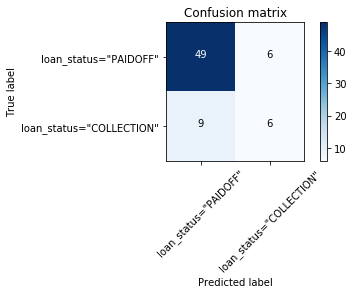

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['loan_status="PAIDOFF"','loan_status="COLLECTION"'],normalize= False,  title='Confusion matrix')

#### Display the Classification Report for K = 7

In [30]:
# Display Classification Report
print(classification_report(yhat,test_y))

              precision    recall  f1-score   support

  COLLECTION       0.40      0.50      0.44        12
     PAIDOFF       0.89      0.84      0.87        58

    accuracy                           0.79        70
   macro avg       0.65      0.67      0.66        70
weighted avg       0.81      0.79      0.79        70



# Decision Tree

Split the *dataset* into **training and testing sets**

In [31]:
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=3)

Begin by importing the `DecisionTreeClassifier` and testing the *different* **permutations**
of **entropy** and **splitter** parameters.

In [32]:
from sklearn.tree import DecisionTreeClassifier
entropies = {'gini','entropy'}
splitters = {'best','random'}

combos    = []
for e in entropies:
    for s in splitters:
        combos.append([e,s])

combos

[['entropy', 'best'],
 ['entropy', 'random'],
 ['gini', 'best'],
 ['gini', 'random']]

### Test with Different Combination of (Entropy,Splitter,Max Depth)

In [35]:

min_depth = 4
max_depth = 25

def output_evaluation_decision(combos,X,y,min_depth=3,max_depth=100,test_size=0.3,random_state=2):
    output = defaultdict(list)
    for combo in combos:
        criterion, splitter = combo
        for depth in range(min_depth,max_depth+1):
            dtree = DecisionTreeClassifier(criterion=criterion,splitter=splitter,max_depth=depth)
            dtree.fit(train_x,train_y)
            
            yhat  = dtree.predict(test_x)
            yhat_prob = dtree.predict_proba(test_x)
            
            yhat_encode   = encode_loan_status(yhat)
            test_Y_encode = encode_loan_status(test_y)
            
            score = metrics.accuracy_score(test_y,yhat)
            jaccard = jaccard_score(test_Y_encode,yhat_encode)
            f1    = f1_score(test_Y_encode,yhat_encode)
            log   = log_loss(test_Y_encode,yhat_prob)
            output['criterion'].append(criterion)
            output['splitter'].append(splitter)
            output['max depth'].append(depth)
            output['metrics'].append(score)
            output['f1 score'].append(f1)

    df = pd.DataFrame(data=output)
    return df

output = output_evaluation_decision(combos,X,y,min_depth,max_depth)
output[output['metrics'] == output['metrics'].max()]

,criterion,splitter,max depth,metrics,f1 score
22,entropy,random,4,0.711538,0.819277


Since the accuracy score is *highest* with `max_depth=4` the **max depth parameter will be 4** the `criterion` will be **entropy** and `splitter`
will be **random** to prevent *overfitting*

In [36]:
dtree = DecisionTreeClassifier(criterion='entropy',splitter='random',max_depth=4)
dtree.fit(train_x,train_y)
yhat = dtree.predict(test_x)
yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', '

In [37]:
print("The optimal Decision Tree's accuracy is %f" % metrics.accuracy_score(test_y,yhat))

The optimal Decision Tree's accuracy is 0.711538


### Visualize the Decision Tree
Begin by importing and downloading the **needed libraries**

In [317]:
!conda install -c anaconda python-graphviz -y
!conda install -c anaconda pydotplus -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cairo-1.14.12              |       h8948797_3         1.3 MB  anaconda
    fribidi-1.0.10             |       h7b6447c_0         115 KB  anaconda
    graphite2-1.3.14           |       h23475e2_0         102 KB  anaconda
    graphviz-2.40.1            |       h21bd128_2         6.9 MB  anaconda
    harfbuzz-1.8.8             |       hffaf4a1_0         863 KB  anaconda
    pango-1.42.4               |       h049681c_0         528 KB  anaconda
    pixman-0.40.0              |       h7b6447c_0         62

In [38]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn import tree
%matplotlib inline 


### Visualize and Plot the Decision Tree
Plot the Decision Tree with Training Set's **features** and Training Set's **Values**

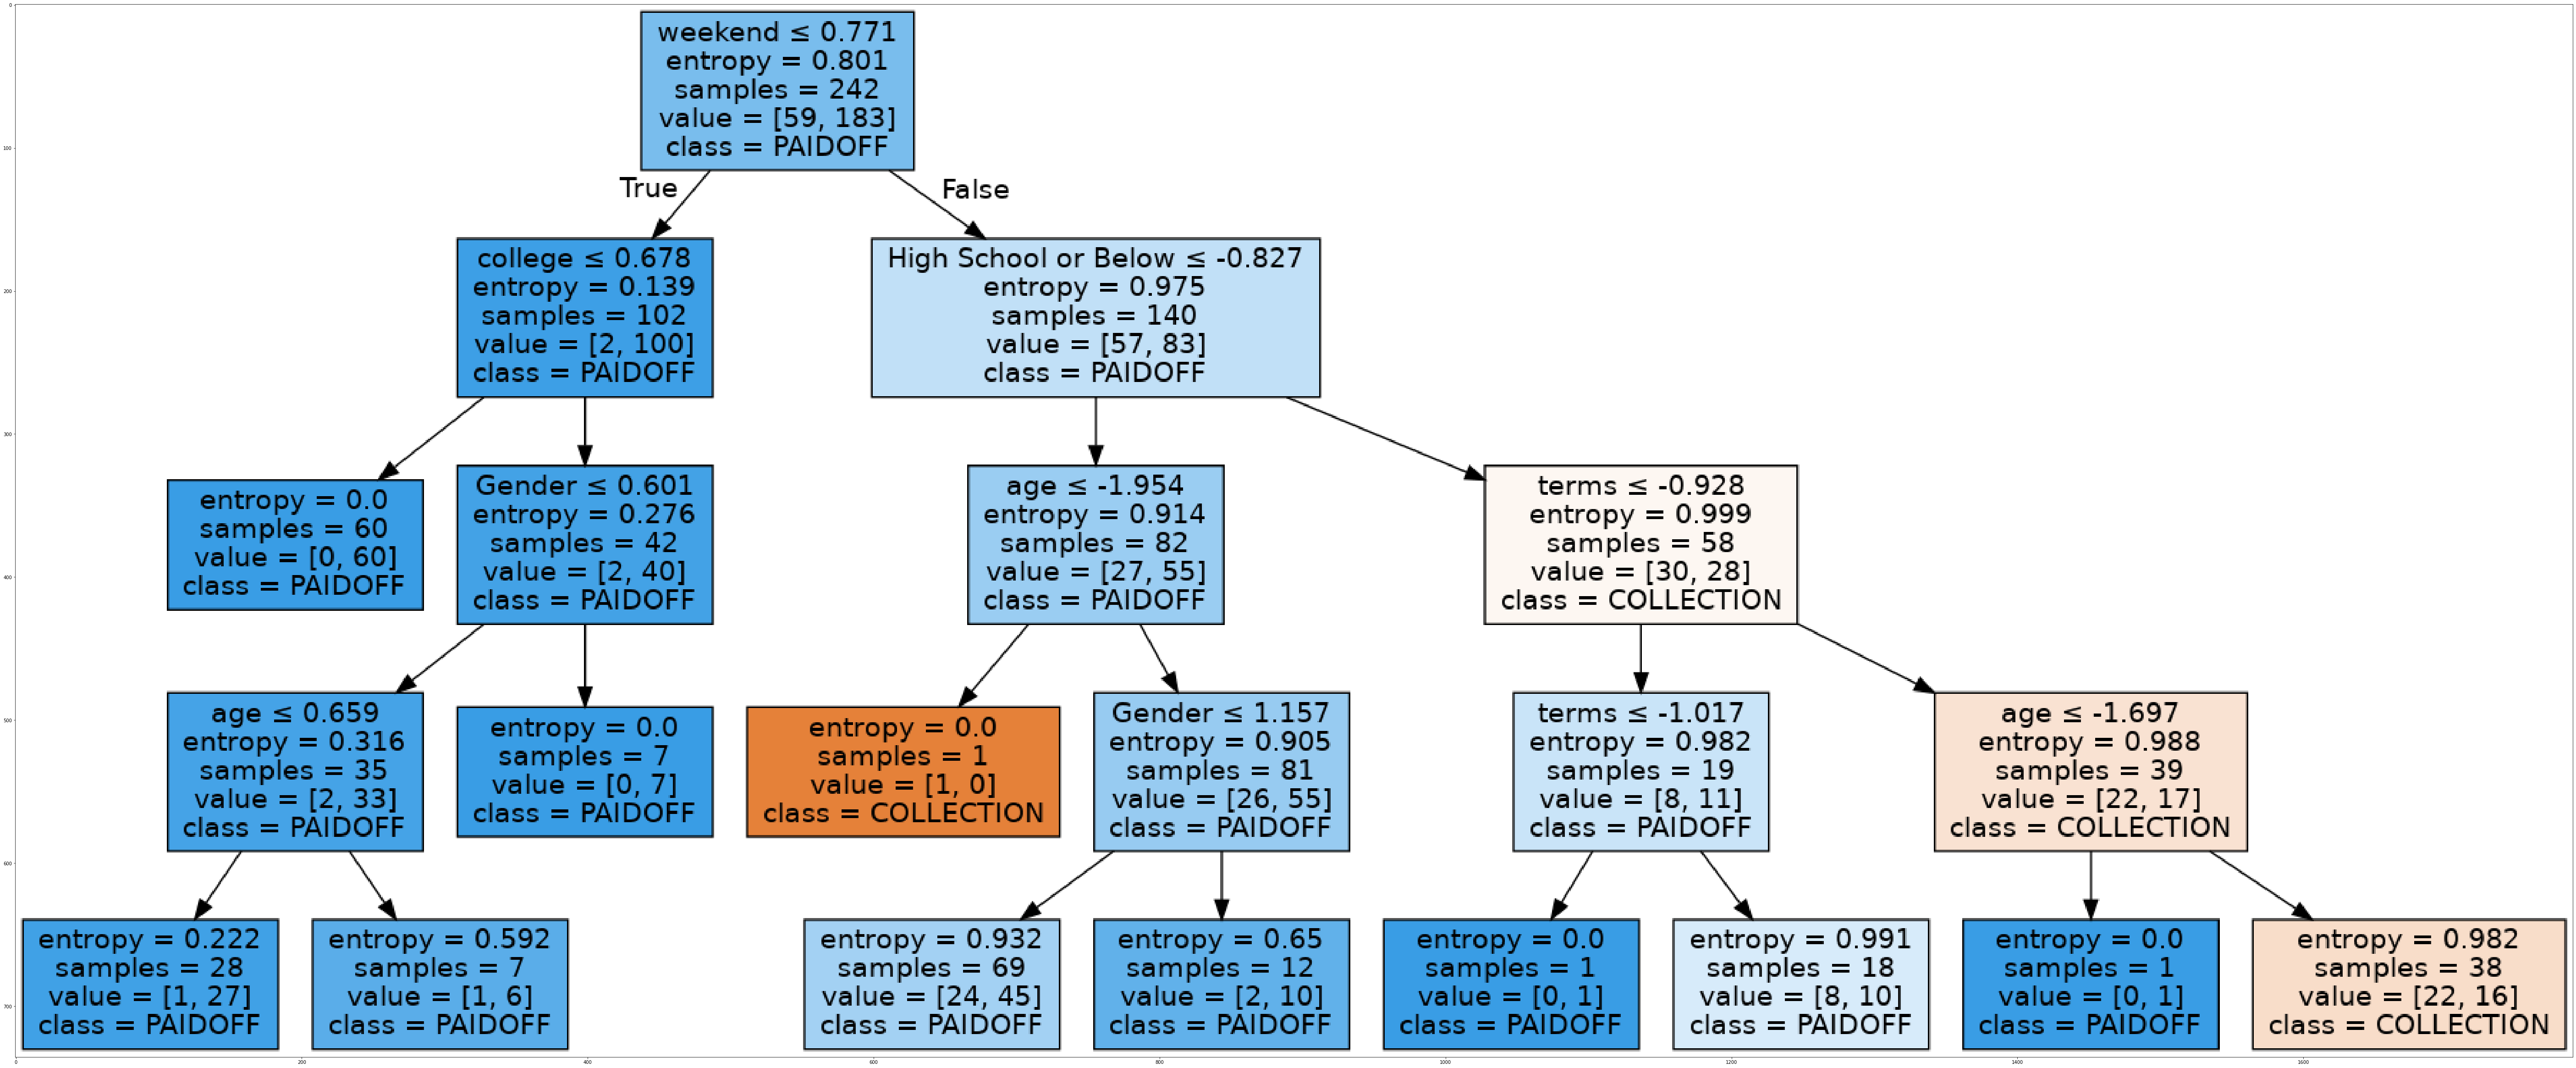

In [39]:
dot_data = StringIO()
filename = "loantree.png"
#features = df.columns[0:8]
features = ['Principal','terms','age','Gender','weekend','Bechalor','High School or Below','college']
out=tree.export_graphviz(dtree,feature_names=features, out_file=dot_data, class_names= np.unique(train_y), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

### Plot the Confusion Matrix and Classification for Decision Tree

Confusion matrix, without normalization
[[68  9]
 [21  6]]


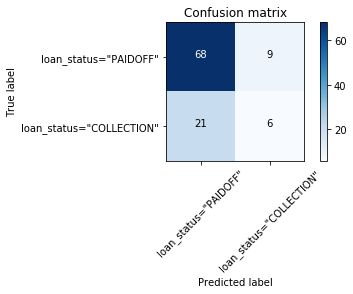

In [40]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['loan_status="PAIDOFF"','loan_status="COLLECTION"'],normalize= False,  title='Confusion matrix')

In [41]:
print(classification_report(test_y,yhat))

              precision    recall  f1-score   support

  COLLECTION       0.40      0.22      0.29        27
     PAIDOFF       0.76      0.88      0.82        77

    accuracy                           0.71       104
   macro avg       0.58      0.55      0.55       104
weighted avg       0.67      0.71      0.68       104



# Support Vector Machine

Begin by creating the **training** and **testing** data sets.

In [58]:
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=4)
print("Train X Shape: ",train_x.shape)
print("Test X Shape: ",test_x.shape)
print("Train Y Shape: ",train_y.shape)
print("Test Y Shape: ",test_y.shape)

Train X Shape:  (242, 8)
Test X Shape:  (104, 8)
Train Y Shape:  (242,)
Test Y Shape:  (104,)


### Testing different Hyperparameter Combinations
Test an **SVM Classifier** with different `kernel` and `gamma` *parameters* combinations

In [59]:
kernels = {'rbf','linear','sigmoid','poly'}
gammas  = {'scale','auto'}

combos  = []
for k in kernels:
    for g in gammas:
        combos.append({k,g})
combos

[{'auto', 'poly'},
 {'poly', 'scale'},
 {'auto', 'sigmoid'},
 {'scale', 'sigmoid'},
 {'auto', 'rbf'},
 {'rbf', 'scale'},
 {'auto', 'linear'},
 {'linear', 'scale'}]

### Perform Evaluation and Visualize Results
Test the different **hyperparameter combinations** and visualize the *accuracy* 
with the **testing dataset**

In [60]:
from sklearn.svm import SVC

def output_svm_evaluation(X,y,kernels,gammas,test_size=0.3,random_state=3):
    output_map = defaultdict(list)
    for kernel in kernels:
        for gamma in gammas:
            svm = SVC(kernel=kernel,gamma=gamma)
            svm.fit(train_x,train_y)
            yhat = svm.predict(test_x)
            yhat_encode = encode_loan_status(yhat)
            test_Y_encode = encode_loan_status(test_y)
            output_map['kernel'].append(kernel)
            output_map['gamma'].append(gamma)
            output_map['metrics'].append(metrics.accuracy_score(test_y,yhat))
            output_map['jaccard score'].append(jaccard_score(test_y,yhat,pos_label='PAIDOFF'))
            output_map['f1 score'].append(f1_score(test_Y_encode,yhat_encode,average='weighted'))
    df = pd.DataFrame(data = output_map)
    return df
            
output = output_svm_evaluation(X,y,kernels,gammas)
output

,kernel,gamma,metrics,jaccard score,f1 score
0,poly,auto,0.750000,0.745098,0.666854
1,poly,scale,0.750000,0.745098,0.666854
2,sigmoid,auto,0.711538,0.711538,0.615601
3,sigmoid,scale,0.711538,0.711538,0.615601
4,rbf,auto,0.750000,0.747573,0.651984
5,rbf,scale,0.750000,0.747573,0.651984
6,linear,auto,0.740385,0.740385,0.629941
7,linear,scale,0.740385,0.740385,0.629941


From inspection of the above `DataFrame` the **rbf** kernel is the optimal choice for the kernel

In [61]:
svm = SVC(kernel='rbf')
svm.fit(train_x,train_y)
yhat = svm.predict(test_x)
yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF

### Evaluate 'RBF' with Confusion Matrix

Confusion matrix, without normalization
[[77  0]
 [26  1]]


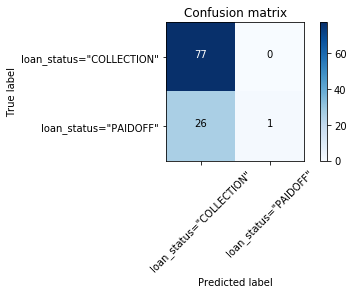

In [62]:
cnf_matrix = confusion_matrix(test_y,yhat, labels=['PAIDOFF', 'COLLECTION'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['loan_status="COLLECTION"','loan_status="PAIDOFF"'],normalize= False,  title='Confusion matrix')

In [63]:
print (classification_report(test_y, yhat))

              precision    recall  f1-score   support

  COLLECTION       1.00      0.04      0.07        27
     PAIDOFF       0.75      1.00      0.86        77

    accuracy                           0.75       104
   macro avg       0.87      0.52      0.46       104
weighted avg       0.81      0.75      0.65       104



# Logistic Regression

Begin by creating a **training** and **testing** set.


In [81]:
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=5)
print("Train X Shape: ",train_x.shape)
print("Test X Shape: ",test_x.shape)
print("Train Y Shape: ",train_y.shape)
print("Test Y Shape: ",test_y.shape)

Train X Shape:  (276, 8)
Test X Shape:  (70, 8)
Train Y Shape:  (276,)
Test Y Shape:  (70,)


### Compare Evaluation Metrics for Different Logistic Regresion Solvers

In [82]:
from sklearn.linear_model import LogisticRegression

solvers = {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}

def output_logistic_evaluation(X,y,solvers,C=0.01,test_size=0.3,random_state=5):
    output_map = defaultdict(list)
    for solver in solvers:
        lr = LogisticRegression(solver=solver,C=C)
        lr.fit(train_x,train_y)
        yhat = lr.predict(test_x)
        test_Y_encode = encode_loan_status(test_y)
        yhat_encode   = encode_loan_status(yhat)
        yhat_proba = lr.predict_proba(test_x)
        metric     = metrics.accuracy_score(test_y,yhat)
        jaccard    = jaccard_score(test_y,yhat,pos_label='PAIDOFF')
        f1         = f1_score(test_Y_encode,yhat_encode)
        logLoss    = log_loss(test_y,yhat_proba)
        output_map['solver'].append(solver)
        output_map['metrics'].append(metric)
        output_map['jaccard score'].append(jaccard)
        output_map['f1 score'].append(f1)
        output_map['log loss'].append(logLoss)
            
    df = pd.DataFrame(data=output_map)
    return df
output = output_logistic_evaluation(X,y,solvers)
output

,solver,metrics,jaccard score,f1 score,log loss
0,liblinear,0.7,0.695652,0.820513,0.585848
1,sag,0.7,0.700000,0.823529,0.566706
2,saga,0.7,0.700000,0.823529,0.566704
3,lbfgs,0.7,0.700000,0.823529,0.566702
4,newton-cg,0.7,0.700000,0.823529,0.566702


From inspecting the above `DataFrame` the `liblinear` **solver** seems to be the optimal hyperparameter for this `LogisticRegression`

In [83]:
lr = LogisticRegression(solver='liblinear',C=0.01)
lr.fit(train_x,train_y)
yhat = lr.predict(test_x)
yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF'], dtype=object)

#### Also Calculate Class Probabilities

In [84]:
yhat_prob = lr.predict_proba(test_x)
yhat_prob

array([[0.5 , 0.5 ],
       [0.47, 0.53],
       [0.49, 0.51],
       [0.5 , 0.5 ],
       [0.47, 0.53],
       [0.44, 0.56],
       [0.45, 0.55],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.49, 0.51],
       [0.45, 0.55],
       [0.49, 0.51],
       [0.31, 0.69],
       [0.27, 0.73],
       [0.29, 0.71],
       [0.43, 0.57],
       [0.32, 0.68],
       [0.47, 0.53],
       [0.31, 0.69],
       [0.49, 0.51],
       [0.31, 0.69],
       [0.43, 0.57],
       [0.3 , 0.7 ],
       [0.3 , 0.7 ],
       [0.42, 0.58],
       [0.45, 0.55],
       [0.43, 0.57],
       [0.31, 0.69],
       [0.46, 0.54],
       [0.48, 0.52],
       [0.49, 0.51],
       [0.3 , 0.7 ],
       [0.49, 0.51],
       [0.31, 0.69],
       [0.29, 0.71],
       [0.34, 0.66],
       [0.5 , 0.5 ],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.31, 0.69],
       [0.46, 0.54],
       [0.5 , 0.5 ],
       [0.44, 0.56],
       [0.26, 0.74],
       [0.45, 0.55],
       [0.49, 0.51],
       [0.33, 0.67],
       [0.46,

### Plot the Confusion Matrix and Classification Report

Confusion matrix, without normalization
[[ 1 20]
 [ 1 48]]


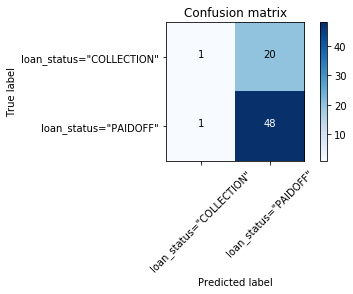

In [85]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, yhat, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['loan_status="COLLECTION"','loan_status="PAIDOFF"'],normalize= False,  title='Confusion matrix')

In [86]:
print(classification_report(test_y,yhat))

              precision    recall  f1-score   support

  COLLECTION       0.50      0.05      0.09        21
     PAIDOFF       0.71      0.98      0.82        49

    accuracy                           0.70        70
   macro avg       0.60      0.51      0.45        70
weighted avg       0.64      0.70      0.60        70



#### Calculate Log Loss of the Logistic Regression Model

In [87]:
jaccard = jaccard_score(test_y,yhat,pos_label='PAIDOFF')
logLoss = log_loss(test_y,yhat_prob)
print("The Jaccard Score of the Logistic Regression is %f" % jaccard)
print("The Log Loss of the Logistic Regression is %f" % logLoss)

The Jaccard Score of the Logistic Regression is 0.695652
The Log Loss of the Logistic Regression is 0.585848


# Model Evaluation using Test set


In [88]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [89]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-07-07 08:04:45--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-07-07 08:04:45 (105 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [90]:
test_df = pd.read_csv('loan_test.csv')

test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Preprocess the Testing / Validation Data Frame

#### Drop and filter Unnecessary Rows and Columns

In [91]:
## Make a copy of data frame
test_df_copy = test_df.copy()

## Drop Rows with education of 'Master or Above'
test_df_copy.drop(test_df_copy[test_df_copy['education'] == 'Master or Above'].index,inplace=True)

#### Convert and Map Datetime Columns to Day of Week and Weekend Columns

In [92]:
## Convert date strings to datetime objects
test_df_copy['due_date'] = pd.to_datetime(test_df_copy['due_date'])
test_df_copy['effective_date'] = pd.to_datetime(test_df_copy['effective_date'])

## Extract the day of the week from the effective date
test_df_copy['dayofweek'] = test_df_copy['effective_date'].dt.dayofweek

## Determine which effective dates are on the weekend
test_df_copy['weekend']   = test_df_copy['dayofweek'].apply(lambda x : 1 if (x > 3) else 0)
test_df_copy.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1
5,37,37,PAIDOFF,700,15,2016-09-11,2016-09-25,33,High School or Below,male,6,1


#### Remap Binary Categories and One Hot Encode String Categories

In [93]:
## Remap Gender to numerical / binary 0 and 1 values
test_df_copy['Gender'].replace(to_replace=['male','female'],value=[0,1],inplace=True)

## One Hot Encode 'Education' Column
dummies       = pd.get_dummies(test_df_copy['education'])

## Append Encoded Categories
test_df_copy  = pd.concat([test_df_copy,dummies],axis=1)

## Remove Columns no longer used in machine learning models
test_df_copy.drop(['Unnamed: 0','Unnamed: 0.1','effective_date','due_date','dayofweek','education'],axis=1,inplace=True)
test_df_copy.head()

,loan_status,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,PAIDOFF,1000,30,50,1,0,1,0,0
2,PAIDOFF,1000,30,43,1,1,0,1,0
3,PAIDOFF,1000,30,26,0,1,0,0,1
4,PAIDOFF,800,15,29,0,1,1,0,0
5,PAIDOFF,700,15,33,0,1,0,1,0


In [94]:
### Extract and Scale the Feature Set from Testing Dataset
val_X = test_df_copy[['Principal','terms','age','Gender','weekend','Bechalor','High School or Below','college']]
val_X = preprocessing.StandardScaler().fit(val_X).transform(val_X)
val_X[0:10]

array([[ 0.49,  0.9 ,  3.06,  1.93, -1.32,  2.35, -0.82, -0.89],
       [ 0.49,  0.9 ,  1.89,  1.93,  0.76, -0.43,  1.21, -0.89],
       [ 0.49,  0.9 , -0.95, -0.52,  0.76, -0.43, -0.82,  1.12],
       [-1.1 , -0.89, -0.45, -0.52,  0.76,  2.35, -0.82, -0.89],
       [-1.9 , -0.89,  0.22, -0.52,  0.76, -0.43,  1.21, -0.89],
       [ 0.49, -0.89, -1.28, -0.52,  0.76, -0.43, -0.82,  1.12],
       [ 0.49,  0.9 ,  0.05, -0.52,  0.76,  2.35, -0.82, -0.89],
       [-1.1 , -0.89, -0.78,  1.93,  0.76, -0.43, -0.82,  1.12],
       [ 0.49, -0.89,  0.89, -0.52,  0.76, -0.43, -0.82,  1.12],
       [-1.1 , -0.89, -1.28, -0.52,  0.76, -0.43,  1.21, -0.89]])

### Extract Y Values ('loan_status') from Testing Dataset

In [95]:
val_y = test_df_copy['loan_status'].values
val_y

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION'], dtype=object)

### KNN Evaluation

In [107]:
yhat_knn      = knn.predict(val_X)
jaccard_knn   = jaccard_score(val_y,yhat_knn,pos_label='PAIDOFF')
f1_knn        = f1_score(val_y,yhat_knn,average='weighted')

print("Jaccard Score for KNN is %f" % jaccard_knn)
print("F1 Score for KNN is %f" % f1_knn)

Jaccard Score for KNN is 0.640000
F1 Score for KNN is 0.619308


### Decision Tree Evaluation


In [109]:
yhat_dtree     = dtree.predict(val_X)
jaccard_dtree  = jaccard_score(val_y,yhat_dtree,pos_label='PAIDOFF')
f1_dtree       = f1_score(val_y,yhat_dtree,average='weighted')

print("Jaccard Score for Decision Tree is %f" % jaccard_dtree)
print("F1 Score for Decsion Tree is %f" % f1_dtree)

Jaccard Score for Decision Tree is 0.730769
F1 Score for Decsion Tree is 0.617094


### SVM Classifier Evaluation

In [110]:
yhat_svm     = svm.predict(val_X)
jaccard_svm  = jaccard_score(val_y,yhat_svm,pos_label='PAIDOFF')
f1_svm       = f1_score(val_y,yhat_svm,average='weighted')

print("Jaccard Score for SVM is %f" % jaccard_svm)
print("F1 Score for SVM is %f" % f1_svm)

Jaccard Score for SVM is 0.711538
F1 Score for SVM is 0.607606


### Logistic Regression Evaluation
Include the `log_loss` value as well

In [111]:
yhat_log        = lr.predict(val_X)
yhat_log_proba  = lr.predict_proba(val_X)
jaccard_log     = jaccard_score(val_y,yhat_log,pos_label='PAIDOFF')
f1_log          = f1_score(val_y,yhat_log,average='weighted')
logLoss         = log_loss(val_y,yhat_log_proba)

print("Jaccard Score for Logistic Regression is %f" % jaccard_log)
print("F1 Score for Logistic Regression is %f" % f1_log)
print("Log Loss for Logistic Regression is %f" % logLoss)

Jaccard Score for Logistic Regression is 0.730769
F1 Score for Logistic Regression is 0.617094
Log Loss for Logistic Regression is 0.570073


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.64    | 0.619308 | NA      |
| Decision Tree      | 0.730769| 0.617094 | NA      |
| SVM                | 0.711538| 0.607606 | NA      |
| LogisticRegression | 0.730769| 0.617094 | 0.570073|


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description |
|---|---|---|---|
| 2020-10-27 | 2.1 | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27 | 2.0 | Malika Singla | Added lab to GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
